# Using weighted overlay analysis to identify areas that are natural and accessible

This sample identifies areas in the State of Washington that are "natural" and easy to travel within based on the following criteria:

* elevation (lower elevations are easier to travel)
* steepness of the terrain (lower slopes are easier to travel)
* degree of human alteration of the landscape (less altered landscapes are more natural)

The input data for this analysis includes a DEM (Digital Elevation Model), and a dataset showing the degree of human modification to the landscape.
## Weighted overlay analysis
The weighted overlay is a standard GIS analysis technique often used for solving multicriteria problems such as generating surfaces representing site-suitability and travel-cost. Weighted overlay is used when a number of factors of variying importance should be considered to arrive at a final decision. This sample shows how raster anlaysis and raster arithmetic can be used to perform such analysis to solve spatial problems. The graphic below explains the logic behind weighted overlay, refer to this help for [a detailed information on weighted overlay analysis](http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-weighted-overlay-works.htm)

![](http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/GUID-D6D1FED1-18BA-4CFC-A056-498736B56C89-web.gif)

In the illustration, the two input rasters have been reclassified to a common measurement scale of 1 to 3. Each raster is assigned a percentage influence. The cell values are multiplied by their percentage influence, and the results are added together to create the output raster. For example, consider the upper left cell. The values for the two inputs become (2 * 0.75) = 1.5 and (3 * 0.25) = 0.75. The sum of 1.5 and 0.75 is 2.25. Because the output raster from Weighted Overlay is integer, the final value is rounded to 2. 

## Connect to the GIS

In [1]:
# import GIS from the arcgis.gis module
from arcgis.gis import GIS

In [2]:
# Connect to the GIS
try:
    gis = GIS('https://python.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
    print("Successfully connected to {0}".format(gis.properties.name))
except:
    print("failed to connect...")

Successfully connected to Python Playground


## Access the data for analysis

<Item title:"Human Modification for North America" type:Imagery Layer owner:arcgis_python>
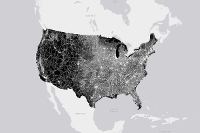

In [3]:
# Search for the Human Modified Index imagery layer item by title
hmna_item = gis.content.search('title:Human Modification for North America', 'Imagery Layer')[0]
hmna_item

<Item title:"National Elevation Dataset (NED)" type:Imagery Layer owner:arcgis_python>
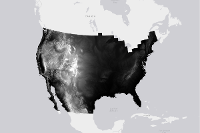

In [4]:
# Search for the DEM imagery layer item by title
elev_item = gis.content.search('title:National Elevation Dataset (NED)', 'Imagery Layer')[0]
elev_item

## Get the study area geometry using data from the Living Atlas

<Item title:"USA States (Generalized)" type:Feature Layer Collection owner:esri_livingatlas>
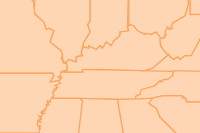

In [5]:
# Access the USA States item from the Living Atlas
states_item = gis.content.search("id:99fd67933e754a1181cc755146be21ca", 'Feature Layer', outside_org=True)[0]
states_item

In [6]:
# Access the USA states feature layer
states_lyr = states_item.layers[0]

We choose the **State of Washington** as our study area for this example.

In [7]:
# Access the feature for the State of Washington
study_area_query = states_lyr.query("STATE_NAME='Washington'", return_geometry=True)

In [8]:
# Get the geometry of the State of Washington feature.
# We will use this geometry to extract the input data for the study area.
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

## Get the coordinates of the study area extent using geocoding

In [9]:
# Import the geocode function
from arcgis.geocoding import geocode
# Use geocoding to get the location of the study area in the spatial reference of the input data for the analysis.
study_area_gcd = geocode(address='State of Washington, USA', out_sr=hmna_item.layers[0].extent['spatialReference'])
# Get the geographic extent of the study area.
# This extent will be used for displaying the input data and output results.
study_area_extent = study_area_gcd[0]['extent']
study_area_extent

{'xmax': -1451059.3770040546,
 'xmin': -2009182.5321227335,
 'ymax': 1482366.818700374,
 'ymin': 736262.260048952}

# Preview the analysis data

### Human Modification for North America

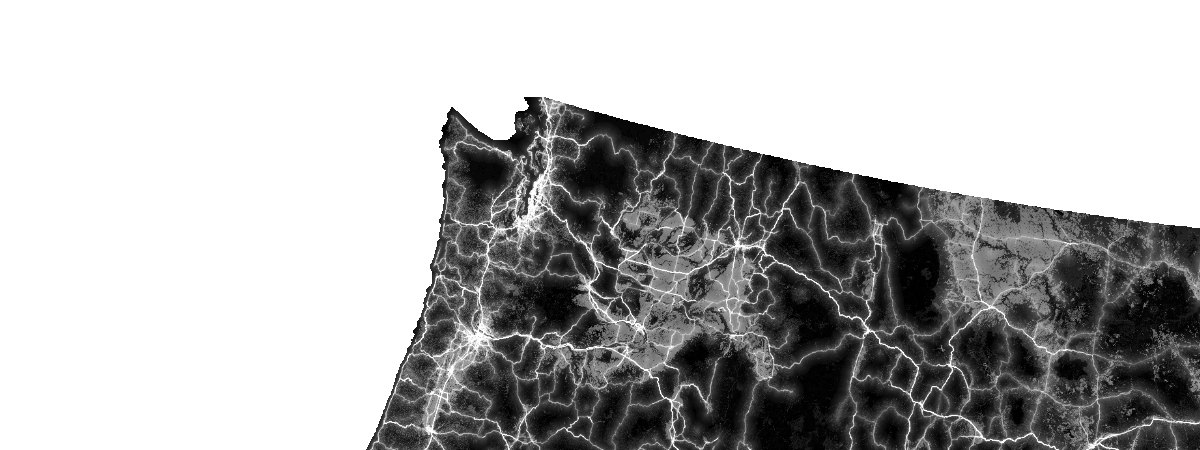

In [10]:
# Get a reference to the imagery layer from the portal item
hmna_lyr = hmna_item.layers[0]
# Set the layer extent to geographic extent of study area and display the data.
hmna_lyr.extent = study_area_extent
hmna_lyr

### Elevation

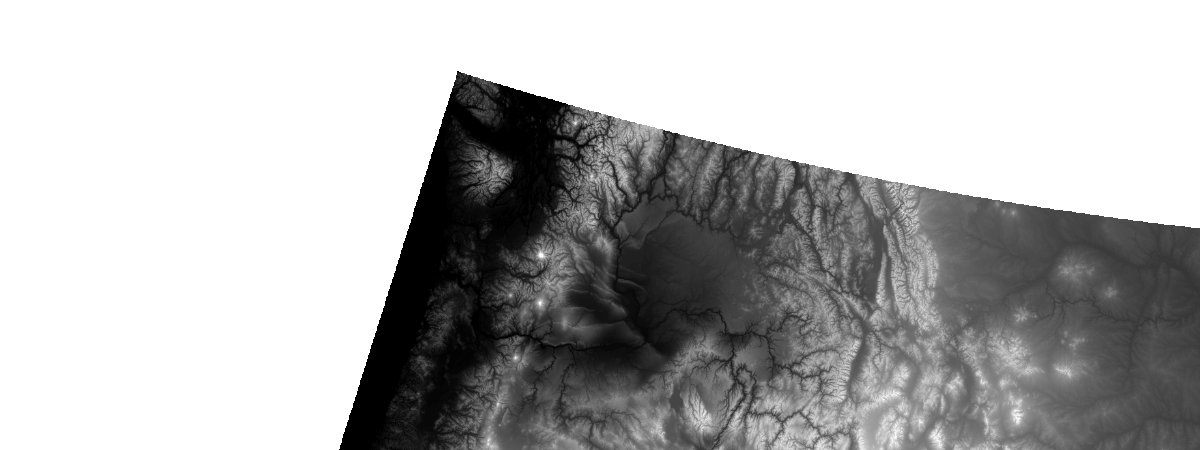

In [11]:
# Get a reference to the imagery layer from the portal item
elev_lyr = elev_item.layers[0]
# Set the layer extent to the geographic extent of study area and display the data.
elev_lyr.extent = study_area_extent
elev_lyr

### Slope (derived from elevation via the Slope raster function)

In [12]:
# Import the raster functions from the API
from arcgis.raster import functions

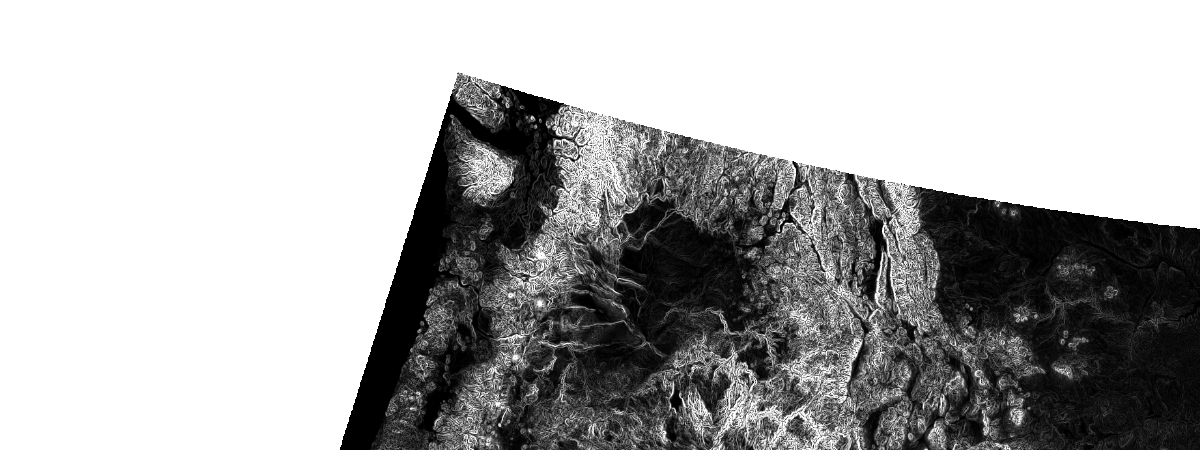

In [13]:
# Derive a slope layer from the DEM layer using the slope function
slope_lyr = functions.slope(dem=elev_lyr, slope_type='DEGREE', z_factor=1)
slope_lyr.extent = study_area_extent
# Use the stretch function to enhance the display of the slope layer.
functions.stretch(raster=slope_lyr, stretch_type='StdDev', dra='true')

# Extract the analysis data within the study area

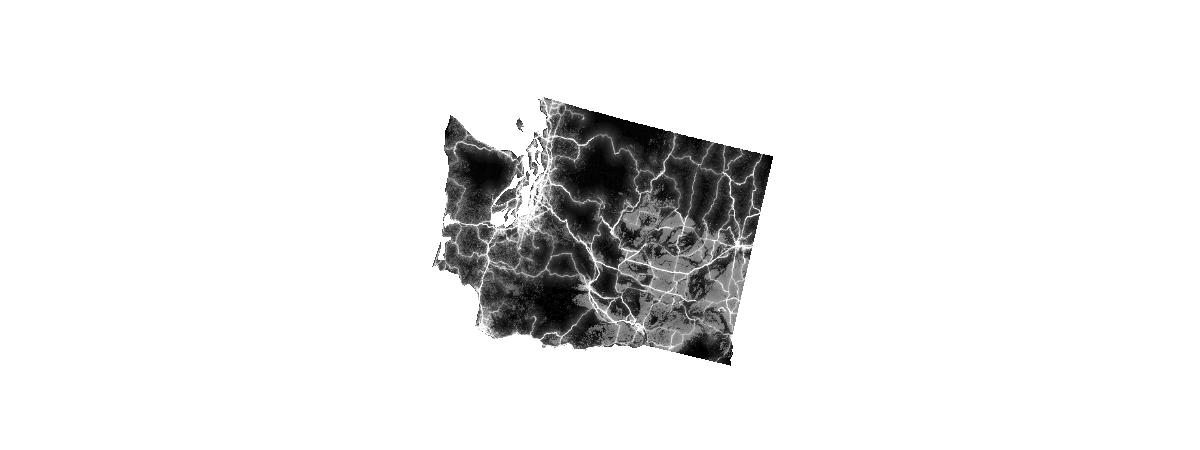

In [14]:
# Human Modification for North America
hmna_study_area = functions.clip(raster=hmna_lyr, geometry=study_area_geom)
hmna_study_area

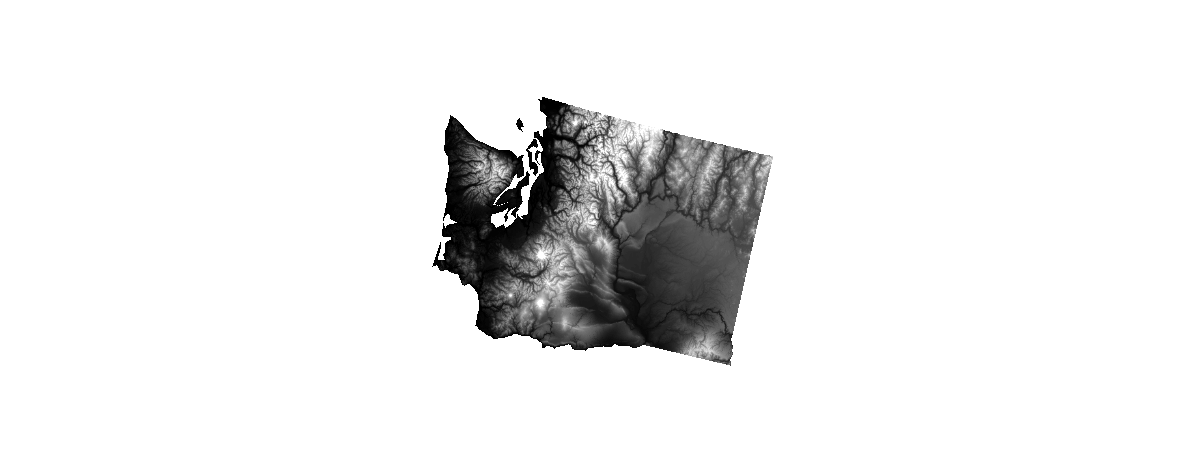

In [15]:
# National Elevation Dataset
elev_study_area = functions.clip(raster=elev_lyr, geometry=study_area_geom)
elev_study_area

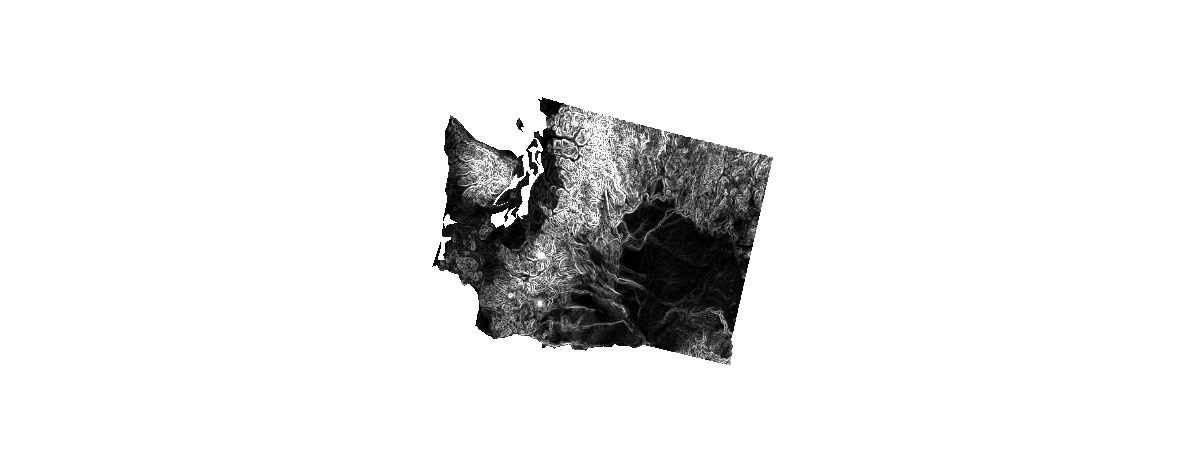

In [16]:
# Slope (derived from the NED via the Slope function)
slope_study_area = functions.clip(raster=slope_lyr, geometry=study_area_geom)
# Apply the Stretch function to enhance the display of the slope_clipped layer.
functions.stretch(raster=slope_study_area, stretch_type='StdDev', dra='true')

# Perform a weighted overlay analysis
Now that we have gathered the different layers required for the analysis and clipped them to the extent of the study area, we can proceed with the weighted overlay analysis

### Step 1: Normalize the input datasets 

In this step we use the Remap function to normalize the input datasets to a common scale of 1 - 9. Locations assigned the value of 1 are considered the least suitable according to our criteria (e.g. the steepest slopes are the least accessible for travel), while locations assigned the value of 9 are considered the most suitable according to our criteria (e.g. areas that are least modified by human activity are more "natural").

![title](images/colormap.png)

In [17]:
# Create a colormap to display the analysis results with 9 colors ranging from red to green to yellow.
clrmap=  [[1, 230, 0, 0], [2, 242, 85, 0], [3, 250, 142, 0], [4, 255, 195, 0], [5, 255, 255, 0], [6, 197, 219, 0],  
          [7, 139, 181, 0], [8, 86, 148, 0], [9, 38, 115, 0]]

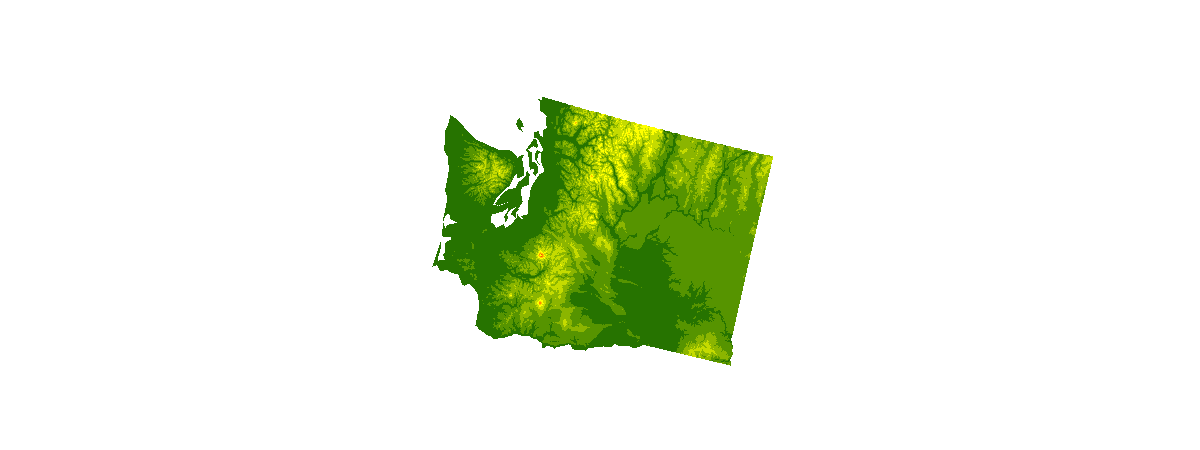

In [18]:
# Reclassify (normalize) the elevation data
elev_normalized = functions.remap(raster=elev_study_area,
                       input_ranges=[0,490, 490,980, 980,1470, 1470,1960, 1960,2450, 
                                     2450,2940, 2940,3430, 3430,3700, 3920,4100],
                       output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
functions.colormap(elev_normalized, colormap=clrmap)

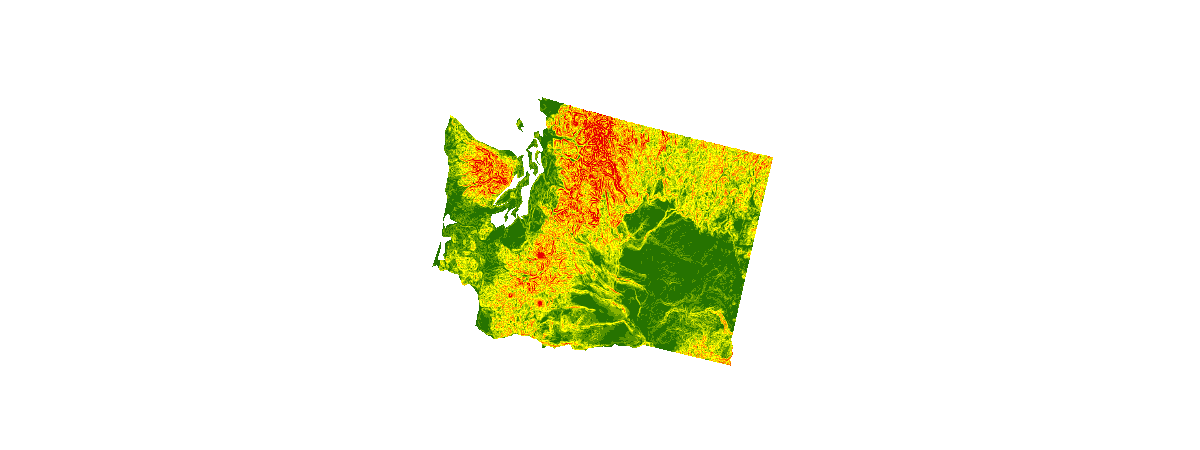

In [19]:
# Reclassify the slope data
slope_normalized = functions.remap(raster=slope_study_area, 
                        input_ranges=[0,1, 1,2, 2,3, 3,5, 5,7, 7,9, 9,12, 12,15, 15,100],
                        output_values=[9,8,7,6,5,4,3,2,1],  astype='U8') 

# Display a color-mapped image of the reclassified slope data
functions.colormap(slope_normalized, colormap=clrmap)

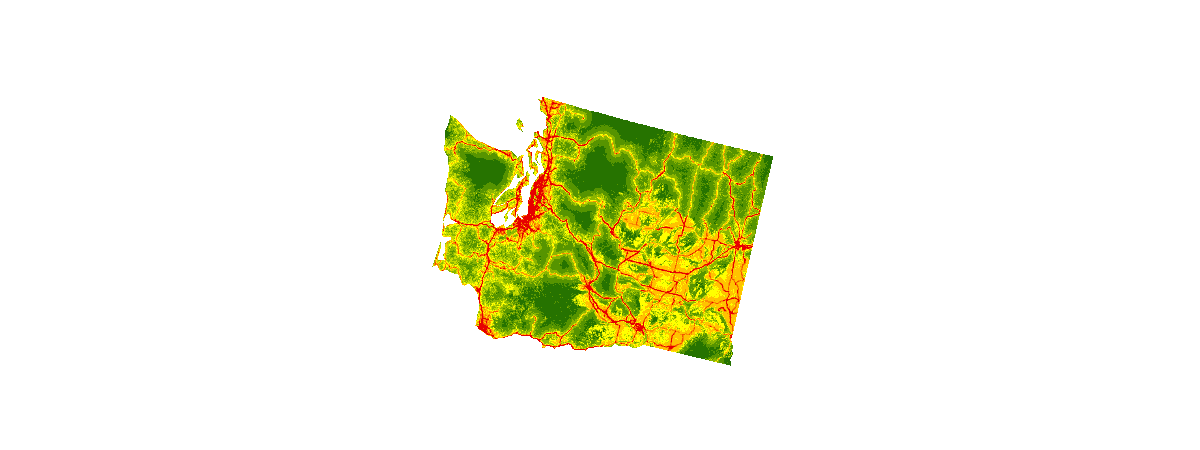

In [20]:
# Reclassify the Human Modified Index data
hmna_normalized = functions.remap(raster=hmna_study_area,
                  input_ranges=[0.0,0.1, 0.1,0.2, 0.2,0.3, 0.3,0.4, 0.4,0.5,
                                0.5,0.6, 0.6,0.7, 0.7,0.8, 0.8,1.1],
                  output_values=[9,8,7,6,5,4,3,2,1],  astype='U8')

# Display a color-mapped image of the reclassified HMI data
functions.colormap(hmna_normalized, colormap=clrmap)

### Step 2: Assign weights to the normalized input datasets based on their relative importance.

In this step we assign "weights" to the normalized inputs by multiplying each of them by a value between 0.0 and 1.0.  The sum of the weight values must equal 1.0 

In [21]:
# Apply weights to the normalized data.
# - Human Modified Index: 60%
# - Slope: 25%
# - Elevation: 15%
hmna_weighted = hmna_normalized * 0.6
slope_weighted = slope_normalized * 0.25
elev_weighted = elev_normalized * 0.15

### Step 3: Calculate the sum of the weighted input datasets.

In this step we calculate the final result of the weighted overlay by calculating the sum of the weighted input datasets.  Areas that are most suitable according to our multi-criteria based on slope, elevation, and degree of human modification are assigned a value of 9 and displayed in green.  Areas that are least suitable are assigned a value of 1 and displayed in red.

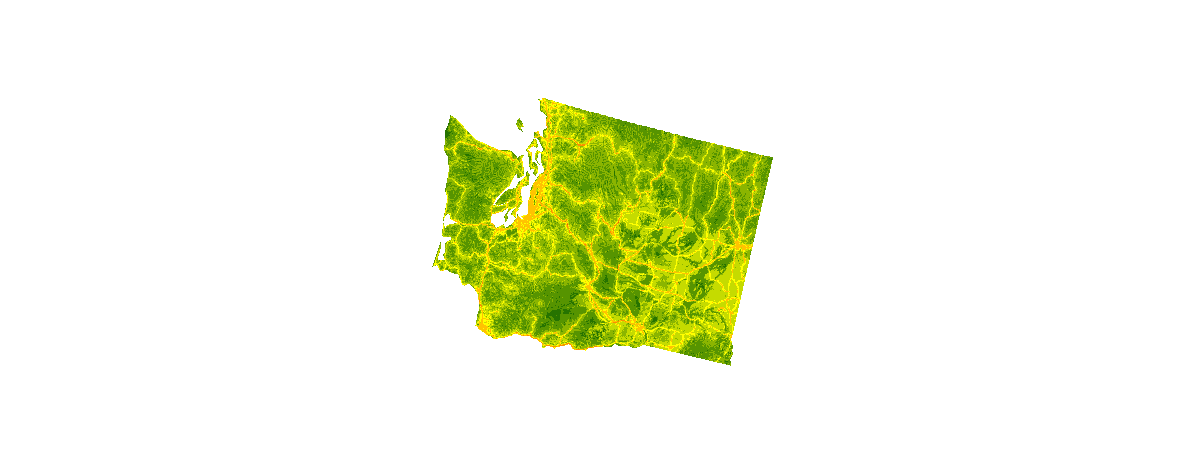

In [22]:
result_dynamic = functions.colormap(hmna_weighted + slope_weighted + elev_weighted, colormap=clrmap)
result_dynamic

###  Perform the analysis in a single operation.
To illustrate the mechanics of a weighted overlay analysis, we just performed each step of the analysis as separate operations.  However, for conciseness, we can also perform a complete analysis in a single operation, for example.

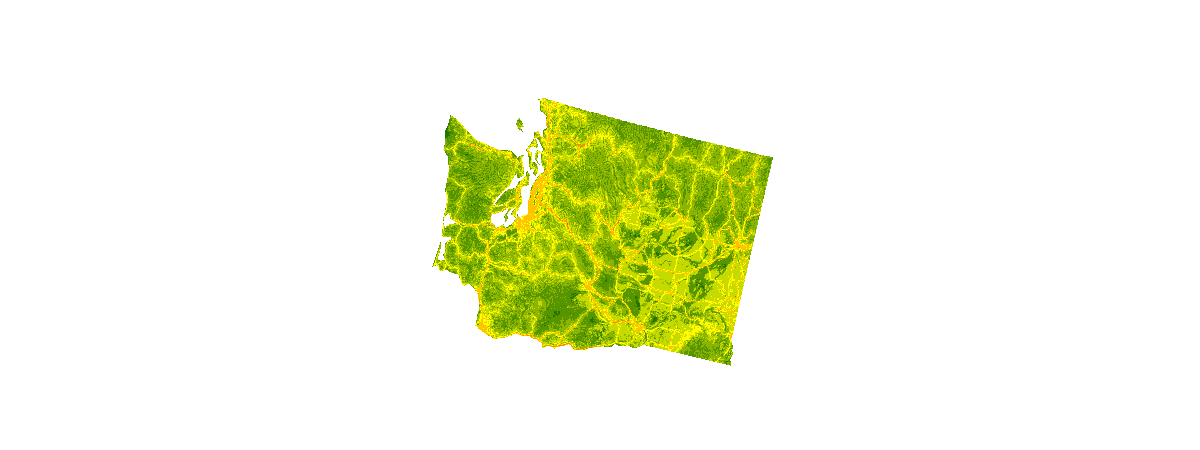

In [23]:
result_dynamic_one_op = functions.colormap(
    raster=
    (
        # Human modified index layer
        0.60 * functions.remap(raster=functions.clip(raster=hmna_lyr, geometry=study_area_geom),
                     input_ranges=[0.0,0.1, 0.1,0.2, 0.2,0.3, 0.3,0.4, 0.4,0.5,
                                   0.5,0.6, 0.6,0.7, 0.7,0.8, 0.8,1.1],
                     output_values=[9,8,7,6,5,4,3,2,1])
        + 
        # Slope layer
        0.25 * functions.remap(raster=functions.clip(raster=slope_lyr, geometry=study_area_geom), 
                     input_ranges=[0,1, 1,2, 2,3, 3,5, 5,7, 7,9, 9,12, 12,15, 
                                   15,100],
                     output_values=[9,8,7,6,5,4,3,2,1]) 
        +
        # Elevation layer
        0.15 * functions.remap(raster=functions.clip(raster=elev_lyr, geometry=study_area_geom), 
                    input_ranges=[-90,250, 250,500, 500,750, 750,1000, 1000,1500, 
                                  1500,2000, 2000,2500, 2500,3000, 3000,5000],
                    output_values=[9,8,7,6,5,4,3,2,1]) 
    ),
    colormap=clrmap,  astype='U8'
)
result_dynamic_one_op

## Generate a persistent analysis result via Raster Analysis on Portal for ArcGIS.
Raster functions perform their calculations on-the-fly. Since no intermediate datasets are created, processes can be applied quickly, as opposed to the time it would take to create a processed file on disk.  On the other hand, Portal for ArcGIS has been enhanced with the ability to perform distributed server based processing on imagery and raster data.  By using Raster Analysis on Portal for ArcGIS you can generate persistent analysis results from raster functions using distributed server-based processing on imagery and raster data. This technology enables you to boost the performance of raster processing by processing data in a distributed fashion, even at full resolution and full extent. The results of this processing can be accessed in the form of a web imagery layer that is hosted in the ArcGIS Organization.

For more information, see [Raster analysis on Portal for ArcGIS](https://pro.arcgis.com/en/pro-app/help/data/imagery/raster-analysis-with-portal.htm)

In [24]:
# Does the GIS support raster analytics?
import arcgis
arcgis.raster.analytics.is_supported(gis)

True

### Invoking Raster Analysis on Portal for ArcGIS

The .save() function invokes generate_raster from the arcgis.raster.analytics
module to run the analysis at the source resolution of the input datasets and stores the result as a 
persistent web imagery layer in the GIS.  For example...

result_persistent = result_dynamic.save("NaturalAndAccessible_WashingtonState")

A persistent analysis result has already been generated for this sample.  We conclude by comparing the persistent result obtained via Raster Analysis on Portal for ArcGIS with the temporary result obtained via on-the-fly processing.

In [25]:
# Search for the persistent analysis result that was generated via Raster Analytics on the GIS.
search_persistent_result = gis.content.search(query="title:NaturalAndAccessible_WashingtonState")[0]
search_persistent_result

<Item title:"NaturalAndAccessible_WashingtonState" type:Imagery Layer owner:arcgis_python>

In [26]:
# Create a map to display the persistent analysis result in a map
map1 = gis.map('State of Washington, USA')
map1.add_layer(search_persistent_result)
# Create a map to display the dynamic analysis result in another map.
map2 = gis.map('State of Washington, USA')
map2.add_layer(result_dynamic)

In [27]:
map1

In [28]:
map2

In [29]:
# Display the two maps side-by-side
from ipywidgets import *
map1.layout = Layout(flex='1 1', padding = '10px')
map2.layout = Layout(flex='1 1', padding = '10px')
box = HBox([map1, map2])
box

# Conclusions

Raster functions apply processing directly to the pixels of imagery and raster datasets.  There are many out-of-the-box functions that can be used for radiometric correction, geometric correction, data management, visualization, and for analysis, as shown in this sample.  You may have noticed that the analysis results from on-the-fly processing are not identical to those from Raster Analysis on Portal for ArcGIS.  With on-the-fly processing, each time the map is re-drawn, the analysis is executed at the resolution of the visible screen pixels, which are resampled from the pixels in the source data to lower resolutions as you zoom out to smaller map scales.  This dynamic resampling behavior is a feature of on-the-fly processing that enables raster functions to maintain a consistent level of high performance over a broad range of map scales.  In contrast, with Raster Analysis on Portal for ArcGIS, the analysis is run by default at the full resolution of the source data.  Therefore the differences in the two results become less pronounced as you zoom in to larger map scales.  